In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Loading the Dataset

In [2]:
cleaned_dataset = pd.read_csv ('filtered_data.csv', encoding='ISO-8859-1')
cleaned_dataset = cleaned_dataset.drop(cleaned_dataset.columns[0], axis = 1)
cleaned_dataset.head()

,seller,offerType,abtest,vehicleType,gearbox,model,fuelType,brand,notRepairedDamage,powerPS_scaled,kilometer_scaled,price,age_of_car_scaled
0,private,listing,test,limousine,manual,golf,diesel,volkswagen,no,0.352941,1.000000,4500.0,0.9
1,private,listing,test,limousine,manual,mondeo,diesel,ford,no,0.549020,1.000000,7300.0,0.8
2,private,listing,test,bus,manual,transporter,diesel,volkswagen,no,0.513725,0.583333,13900.0,0.7
3,private,listing,test,kombi,manual,passat,diesel,volkswagen,no,0.549020,1.000000,7450.0,1.0
4,private,listing,test,kombi,automatic,signum,diesel,opel,no,0.588235,0.583333,7600.0,1.0


## Encoding the Categorical Features

In [3]:
categorical_columns = ["seller", "offerType","abtest","vehicleType","gearbox","model","fuelType","brand","notRepairedDamage"]
encoded_dataset = pd.get_dummies(cleaned_dataset, columns=categorical_columns)
encoded_dataset.head()

,powerPS_scaled,kilometer_scaled,price,age_of_car_scaled,seller_commercial,seller_private,offerType_listing,abtest_control,abtest_test,vehicleType_bus,...,brand_seat,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_volkswagen,brand_volvo,notRepairedDamage_no,notRepairedDamage_yes
0,0.352941,1.000000,4500.0,0.9,0,1,1,0,1,0,...,0,0,0,0,0,0,1,0,1,0
1,0.549020,1.000000,7300.0,0.8,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,0.513725,0.583333,13900.0,0.7,0,1,1,0,1,1,...,0,0,0,0,0,0,1,0,1,0
3,0.549020,1.000000,7450.0,1.0,0,1,1,0,1,0,...,0,0,0,0,0,0,1,0,1,0
4,0.588235,0.583333,7600.0,1.0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0


## Splitting the X and Y train and test sets

In [4]:
X = encoded_dataset.drop('price', axis = 1)
y = encoded_dataset['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=57)

## Scaling the data

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

## 1. Lasso Regression Model

In [52]:
lasso_model = Lasso() 
lasso_model.fit(X_train_scaled, y_train)
y_pred = lasso_model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"RMSE for: {rmse}")
print(f"R-squared: {r2} \n")

Mean Absolute Error: 1615.293239183182
Mean Squared Error: 4945786.816950195
RMSE for: 2223.912502089548
R-squared: 0.7452871063689195 



C:\Users\Shri Gayathiri\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.010e+08, tolerance: 8.757e+07
  model = cd_fast.enet_coordinate_descent(


## Visualizations:

## Line plot of Actual Vs Predicted

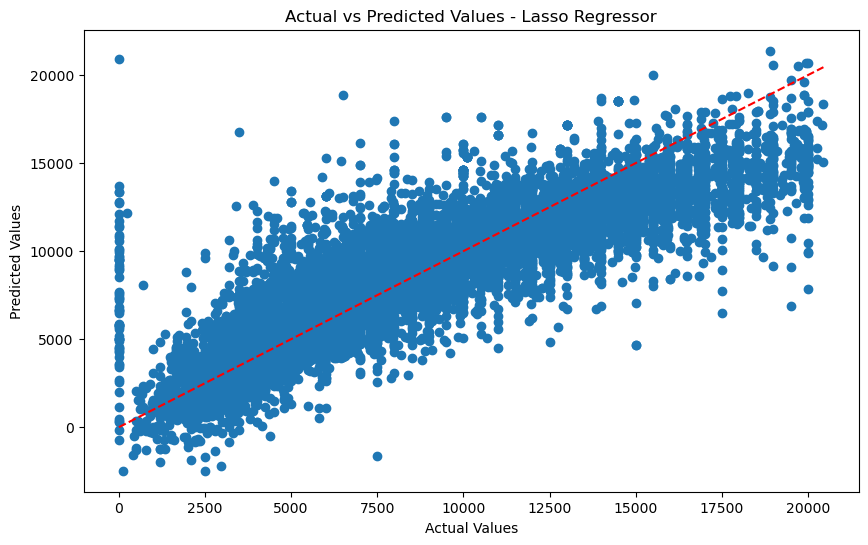

In [80]:
plt.figure(figsize=(10, 6))
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='r')
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values - Lasso Regressor")
plt.show()

## Feature Importance

In [60]:
# https://plotly.com/python/bar-charts/

coefficients = lasso_model.coef_
fig = px.bar(x=np.abs(coefficients), y=X_train.columns, orientation='h', title='Lasso Regression - Feature Importance')
fig.update_layout(yaxis=dict(categoryorder='total ascending'))
fig.update_xaxes(title_text='Coefficient Magnitude')
fig.update_yaxes(title_text='Features')
fig.show()

## Feature Importance - Top 10 Features

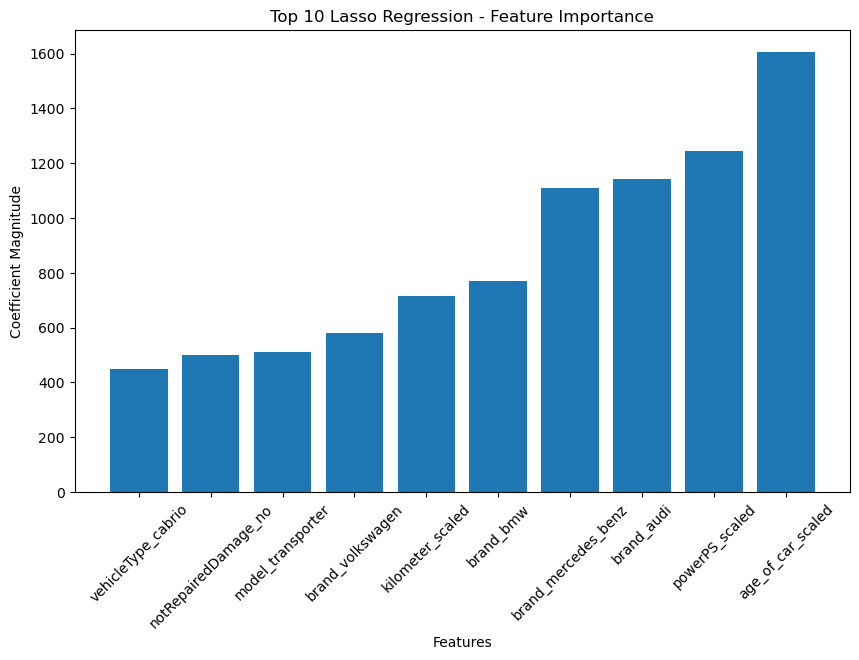

In [77]:
coefficients = lasso_model.coef_
top_n = 10
top_feature_indices = np.argsort(np.abs(coefficients))[-top_n:]
top_feature_names = X_train.columns[top_feature_indices]
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_feature_indices)), np.abs(coefficients[top_feature_indices]))
plt.xticks(range(len(top_feature_indices)), top_feature_names, rotation=45)
plt.xlabel('Features')
plt.ylabel('Coefficient Magnitude')
plt.title(f'Top {top_n} Lasso Regression - Feature Importance')
plt.show()

## Tuning the Model using Cross-Validation: LassoCV

In [12]:
lasso_cv = LassoCV(alphas=np.arange(0.00, 1.0, 0.1), cv=5)
lasso_cv.fit(X_train_scaled, y_train)
best_alpha = lasso_cv.alpha_

final_lasso_model = Lasso(alpha=best_alpha)
final_lasso_model.fit(X_train_scaled, y_train)

y_pred_cv = final_lasso_model.predict(X_test_scaled)

mae_cv = mean_absolute_error(y_test, y_pred_cv)
mse_cv = mean_squared_error(y_test, y_pred_cv)
rmse_cv = mean_squared_error(y_test, y_pred_cv, squared=False)
r2_cv = r2_score(y_test, y_pred_cv)

print(f"Best Alpha: {best_alpha}")
print(f"Mean Absolute Error (MAE): {mae_cv}")
print(f"Mean Squared Error (MSE): {mse_cv}")
print(f"Root Mean Squared Error (RMSE): {rmse_cv}")
print(f"R-squared (R2-Score): {r2_cv}")

C:\Users\Shri Gayathiri\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 150851118.88391113, tolerance: 69595948.52875605
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Shri Gayathiri\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3052987878.8999634, tolerance: 69595948.52875605
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Shri Gayathiri\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Shri Gayathiri\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective 

Best Alpha: 0.8
Mean Absolute Error (MAE): 1615.365619230575
Mean Squared Error (MSE): 4945857.822443706
Root Mean Squared Error (RMSE): 2223.928466125587
R-squared (R2-Score): 0.7452834495160495


C:\Users\Shri Gayathiri\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.759e+08, tolerance: 8.757e+07
  model = cd_fast.enet_coordinate_descent(


## 2. Ridge Regression Model

In [61]:
ridge_model = Ridge()
ridge_model.fit(X_train_scaled, y_train)

y_pred_ridge = ridge_model.predict(X_test_scaled)

mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = mean_squared_error(y_test, y_pred_ridge, squared=False)
r2_ridge= r2_score(y_test, y_pred_ridge)

print(f"Mean Absolute Error: {mae_ridge}")
print(f"Mean Squared Error: {mse_ridge}")
print(f"RMSE: {rmse_ridge}")
print(f"R-squared: {r2_ridge}")

Mean Absolute Error: 1616.8172407508478
Mean Squared Error: 4951214.74980568
RMSE: 2225.13252409956
R-squared: 0.7450075624792967


## Line plot of Actual Vs Predicted

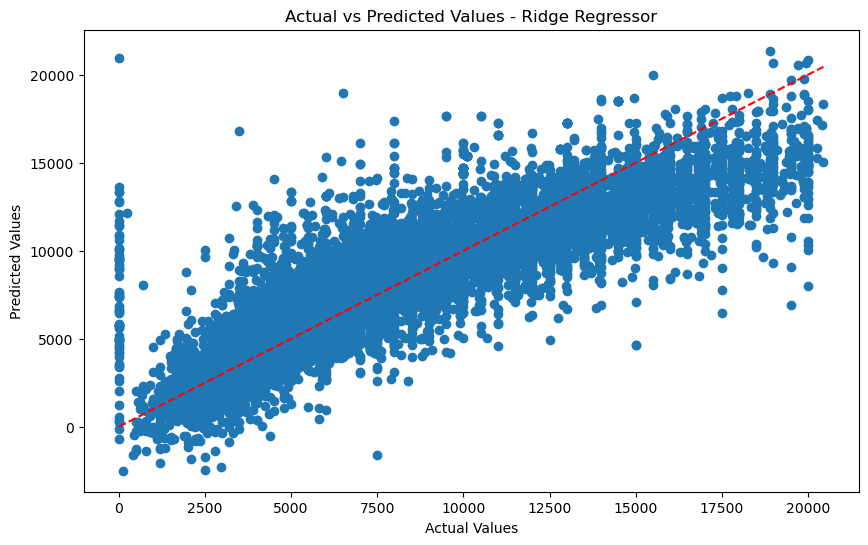

In [87]:
plt.figure(figsize=(10, 6))
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='r')
plt.scatter(y_test, y_pred_ridge)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values - Ridge Regressor")
plt.show()

## Feature Importance

In [64]:
# https://plotly.com/python/bar-charts/

coefficients_ridge = ridge_model.coef_

fig_ridge = px.bar(x=np.abs(coefficients_ridge), y=X_train.columns, orientation='h', title='Ridge Regression - Feature Importance')
fig_ridge.update_layout(yaxis=dict(categoryorder='total ascending'))
fig_ridge.update_xaxes(title_text='Coefficient Magnitude')
fig_ridge.update_yaxes(title_text='Features')
fig_ridge.show()

## Feature Importance - Top 10 Features

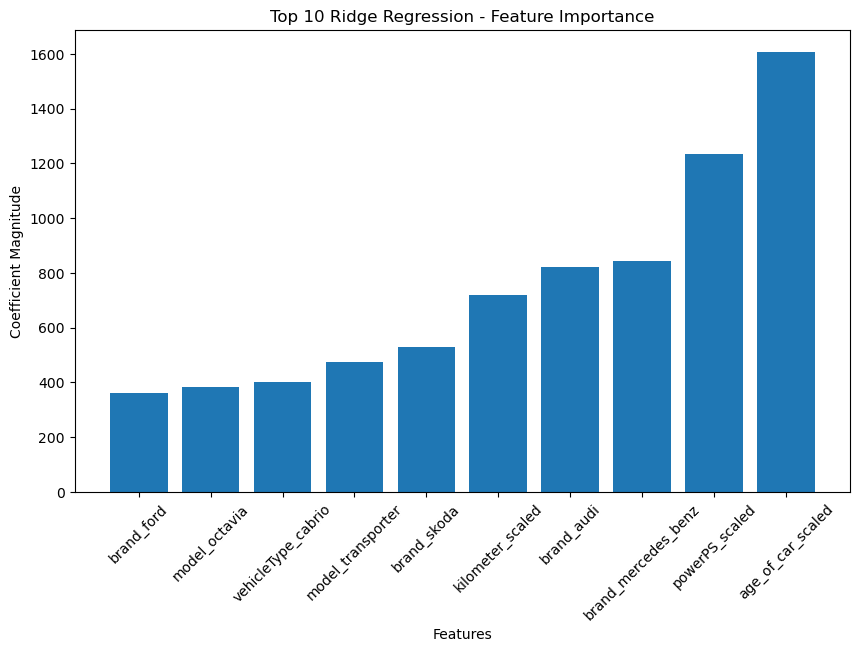

In [78]:
coefficients = ridge_model.coef_

top_n = 10
top_feature_indices = np.argsort(np.abs(coefficients))[-top_n:]
top_feature_names = X_train.columns[top_feature_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(len(top_feature_indices)), np.abs(coefficients[top_feature_indices]))
plt.xticks(range(len(top_feature_indices)), top_feature_names, rotation=45)
plt.xlabel('Features')
plt.ylabel('Coefficient Magnitude')
plt.title(f'Top {top_n} Ridge Regression - Feature Importance')
plt.show()

## Tuning the Model using Cross-Validation: RidgeCV

In [14]:
num_values = 30
alpha_values = np.geomspace(1e-3, 1e3, num=num_values)
ridge_cv_model = RidgeCV(alphas=alpha_values, store_cv_values=True)

ridge_cv_model.fit(X_train_scaled, y_train)
best_alpha = ridge_cv_model.alpha_
y_pred_ridge_cv = ridge_cv_model.predict(X_test_scaled)

mae_ridge_cv = mean_absolute_error(y_test, y_pred_ridge_cv)
mse_ridge_cv = mean_squared_error(y_test, y_pred_ridge_cv)
rmse_ridge_cv = mean_squared_error(y_test, y_pred_ridge_cv, squared=False)
r2_ridge_cv = r2_score(y_test, y_pred_ridge_cv)

print(f"Best Alpha: {best_alpha}")
print(f"Mean Absolute Error (MAE): {mae_ridge_cv}")
print(f"Mean Squared Error (MSE): {mse_ridge_cv}")
print(f"Root Mean Squared Error (RMSE): {rmse_ridge_cv}")
print(f"R-squared (R2-Score): {r2_ridge_cv}")

Best Alpha: 92.36708571873865
Mean Absolute Error (MAE): 1616.343189533927
Mean Squared Error (MSE): 4950982.139779543
Root Mean Squared Error (RMSE): 2225.0802546828604
R-squared (R2-Score): 0.7450195421248086
